In [1]:
import numpy as np
import tensorflow as tf
import pickle
%matplotlib inline
# 讀取 Muist 數字手寫資料 pickle
with open('mnist.pickle', 'rb') as file:
    (x_train, t_train), (x_test, t_test) = pickle.load(file)
x_train = -(x_train-1)
x_test = -(x_test-1)

from PIL import Image

In [2]:
def img_show(img):
    return Image.fromarray(np.uint8(img*255))

def create_layer(inputs, in_size, out_size, n_layer, activation_function=None):
    layer_name = 'layer' + n_layer
    # W & b 初始化條件 init
    W_init = tf.random_normal_initializer(mean=0, stddev=(2.0/in_size)**0.5) # stddev=(2.0/in_size)**0.5
    b_init = tf.zeros_initializer()
    # W & b 變數設定
    W = tf.get_variable(name=layer_name+'_W', shape=[in_size, out_size], initializer=W_init)
    tf.summary.histogram('weights', W) # 紀錄資料
    b = tf.get_variable(name=layer_name+'_b', shape=[out_size], initializer=b_init)
    tf.summary.histogram('biases', b) # 紀錄資料
    Wx_plus_b = tf.add(tf.matmul(inputs, W), b)
    # 激活函數設定
    if activation_function is None:
        outputs = Wx_plus_b
    else:
        outputs = activation_function(Wx_plus_b)
    tf.summary.histogram('outputs', outputs)
    
    return outputs

def conv2d(inputs, W_shape, n_conv, s=1, activation_function=None):
    # input shape (N, H, W, C)
    # filter W shape (FH, FW, C, FN)
    # b shape (FN)
    # output shape (N, OH, OW, FN)
    conv_name = 'conv' + n_conv
    # W & b 初始化條件 init
    in_size = W_shape[0] * W_shape[1] * W_shape[2] # (FH * FW * C)
    W_init  = tf.random_normal_initializer(stddev=(2.0/in_size)**0.5) #stddev=(2.0/incoming)**0.5
    b_init = tf.zeros_initializer()
    # W & b 變數設定
    W = tf.get_variable(name=conv_name+'_W', shape=W_shape, initializer=W_init)
    tf.summary.histogram('weights', W)
    b = tf.get_variable(name=conv_name+'_b', shape=W_shape[3], initializer=b_init)
    tf.summary.histogram('biases', b)
    Wx_plus_b = tf.add(tf.nn.conv2d(inputs, W, strides=[1, s, s, 1], padding='SAME'), b)
    # 激活函數設定
    if activation_function is None:
        outputs = Wx_plus_b
    else:
        outputs = activation_function(Wx_plus_b)
    tf.summary.histogram('outputs', outputs)
    
    return outputs

def max_pool(inputs, k=2, s=1):
    # input shape (N, H, W, C)
    # k = FH, HW
    # output shape (N, OH, OW, C)
    return tf.nn.max_pool(inputs, ksize=[1, k, k, 1], strides=[1, s, s, 1], padding='SAME')

def min_pool(inputs, k=2, s=1):  # 最小池化層
    return -tf.nn.max_pool(-inputs, ksize=[1, k, k, 1], strides=[1, s, s, 1], padding='SAME')

### 圖像範例

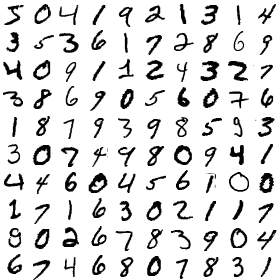

In [3]:
ar = x_train[0:100].reshape(10,10,28,28).transpose(0,2,1,3).reshape(280, 280)
img_show(ar)

In [4]:
FN1 = 16
FN2 = 32
FHW1 = 5
FHW2 = 4

with tf.name_scope('inputs'):
    xs = tf.placeholder(tf.float32, [None, 784], name='x_input')
    ts = tf.placeholder(tf.float32, [None, 10], name='t_input')
    x = tf.reshape(xs, shape=[-1, 28, 28, 1], name='x_reshape')
    keep_prob = tf.placeholder(tf.float32)
    
with tf.variable_scope('conv_A'):
    conv_1 = conv2d(x, [FHW1, FHW1, 1, FN1], n_conv='A', s=1, activation_function=tf.nn.relu)
    pool_1 = min_pool(conv_1, k=2, s=2) #最小池化層

with tf.variable_scope('conv_B'):
    conv_2 = conv2d(pool_1, [FHW2, FHW2, FN1, FN2], n_conv='B', s=1, activation_function=tf.nn.relu)
    pool_2 = min_pool(conv_2, k=2, s=2) #最小池化層

with tf.variable_scope('layer_A'):
    pool2_reshape = tf.reshape(pool_2, [-1, 7*7*FN2])
    layerA = create_layer(pool2_reshape, 7*7*FN2, 256, n_layer='A', activation_function=tf.nn.relu)

layerA_drop = tf.nn.dropout(layerA, keep_prob=keep_prob)

with tf.variable_scope('layer_B'):
    layerB = create_layer(layerA_drop, 256, 10, n_layer='B', activation_function=tf.nn.relu)

y = tf.nn.softmax(layerB)

# cross entropy
with tf.name_scope('loss'):
    loss = -tf.reduce_mean(tf.reduce_sum((ts * tf.log(tf.clip_by_value(y, 1e-16, 1))), axis=1)) # 輸入為 batch 使用平均值 mean
    tf.summary.scalar('loss', loss) # 紀錄資料

#train_way = tf.train.GradientDescentOptimizer(learning_rate=0.01) # Acc : 99.07  (learning_rate=0.01
train_way = tf.train.MomentumOptimizer(learning_rate=0.01, momentum=0.95) # Acc : 99.27  (learning_rate=0.01, momentum=0.92)
#train_way = tf.train.AdamOptimizer() # Acc : 99.23

with tf.name_scope('train'):
    train_step = train_way.minimize(loss)

with tf.name_scope('accuracy'):
    # tf.cast() 改變資料型態 np.astype change dtype
    acc = tf.cast(tf.equal(tf.argmax(y, axis=1), tf.argmax(ts, axis=1)), tf.float32)
    accuracy = tf.reduce_mean(acc, name='accuracy')
    tf.summary.scalar('accuracy', accuracy) # 紀錄資料

sess = tf.Session()
merged = tf.summary.merge_all() # 所以紀錄資料設定
writer = tf.summary.FileWriter("logs/", sess.graph) # 紀錄圖形
sess.run(tf.global_variables_initializer()) # 變數初始化

data_num = x_train.shape[0]
batch = 100
lst = np.arange(data_num)
ii = 0

In [5]:
for i_ in range(5):
    # 隨機打亂資料排序
    np.random.shuffle(lst)
    x_train = x_train[lst]
    t_train = t_train[lst]
   
    for i in range(0, data_num, batch):  # 每 bench 100個資料
        feed_data = {xs: x_train[i:i + batch], ts: t_train[i:i + batch], keep_prob:0.5}
        sess.run(train_step, feed_dict=feed_data)
        
    result = sess.run(merged, feed_dict={xs: x_train[0:10000], ts: t_train[0:10000], keep_prob:1}) # 寫入紀錄
    writer.add_summary(result, ii)
    ii += 1
    
    # Accuracy test data
    acc_test = sess.run(accuracy, feed_dict={xs: x_test, ts: t_test, keep_prob:1})
    acc_train = sess.run(accuracy, feed_dict={xs: x_train[0:10000], ts: t_train[0:10000], keep_prob:1})
    print('%3d  train:%.4f  test:%.4f'%(ii, acc_train, acc_test))

  1  train:0.9509  test:0.9558
  2  train:0.9674  test:0.9676
  3  train:0.9790  test:0.9778
  4  train:0.9819  test:0.9788
  5  train:0.9798  test:0.9740
  6  train:0.9817  test:0.9814
  7  train:0.9867  test:0.9809
  8  train:0.9874  test:0.9829
  9  train:0.9895  test:0.9844
 10  train:0.9903  test:0.9861


In [5]:
#sess.close()

# in win10 open powershell key:  tensorboard --logdir="logs" 

In [6]:
n = 10
s = 2000
cov1, pol1, cov2, pol2 = sess.run([conv_1, pool_1, conv_2, pool_2], feed_dict={xs: x_train[s:s+n**2]})
layA, layB = sess.run([layerA, layerB], feed_dict={xs: x_train[s:s+n**2],keep_prob:1})

In [7]:
cov1 = cov1.reshape(n,n,28,28,4,4).transpose(4,0,2,5,1,3).reshape(4*n*28, 4*n*28)
pol1 = pol1.reshape(n,n,14,14,4,4).transpose(4,0,2,5,1,3).reshape(4*n*14, 4*n*14)
cov2 = cov2.reshape(n,n,14,14,4,8).transpose(4,0,2,5,1,3).reshape(4*n*14, 8*n*14)
pol2 = pol2.reshape(n,n,7,7,4,8).transpose(4,0,2,5,1,3).reshape(4*n*7, 8*n*7)
ar = x_train[s:s+n**2].reshape(n,n,28,28).transpose(0,2,1,3).reshape(n*28, n*28)

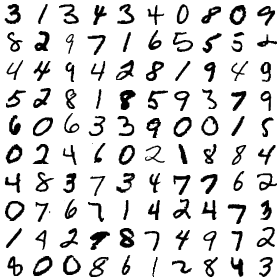

In [8]:
img_show(ar)

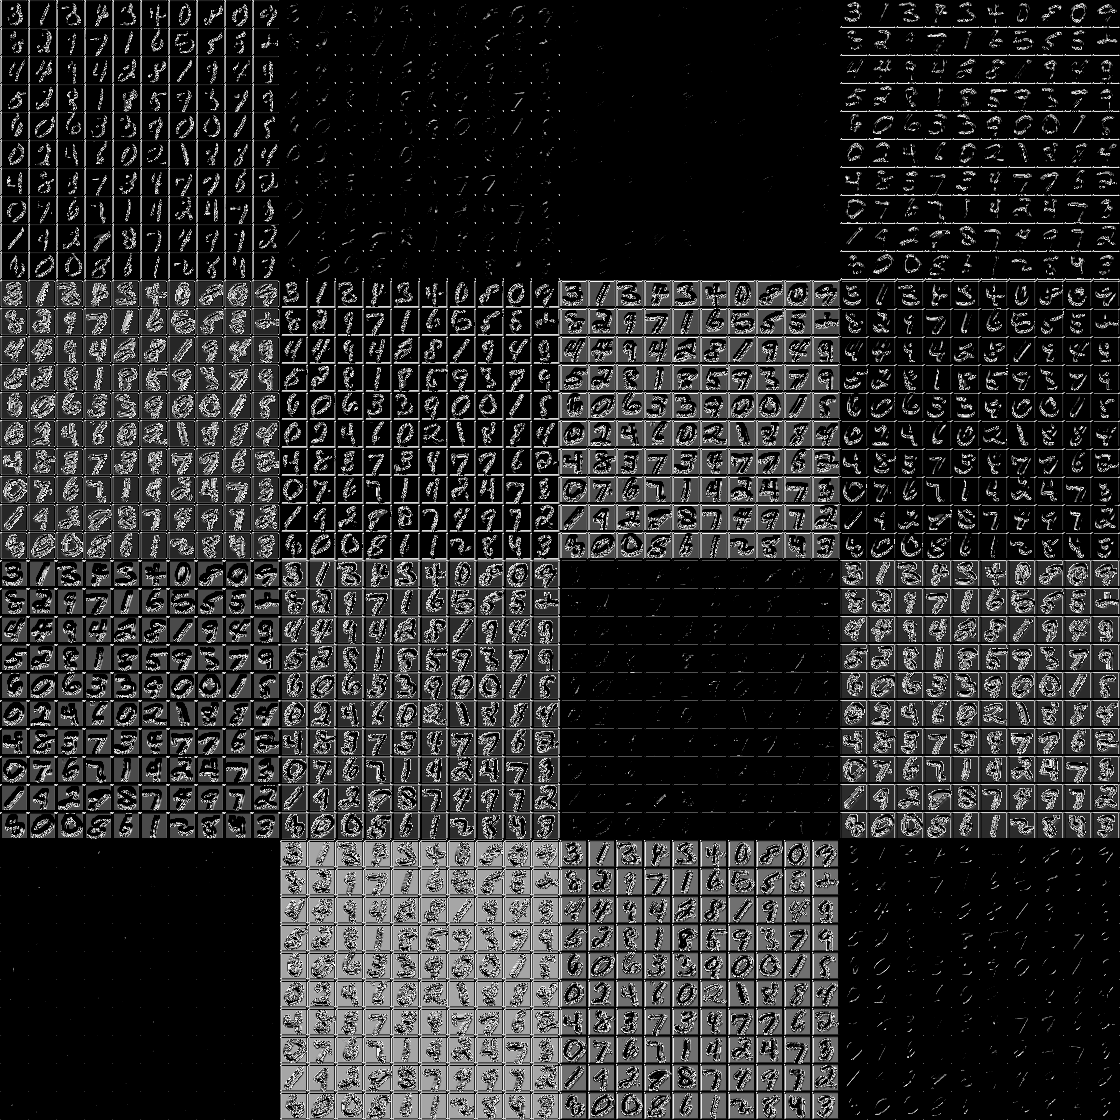

In [9]:
img_show(cov1)

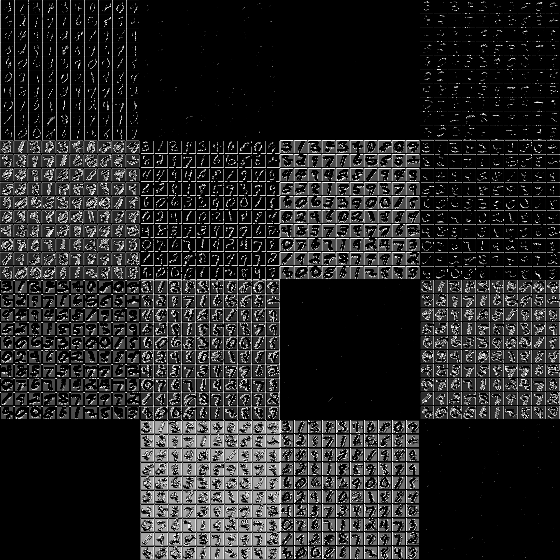

In [10]:
img_show(pol1)

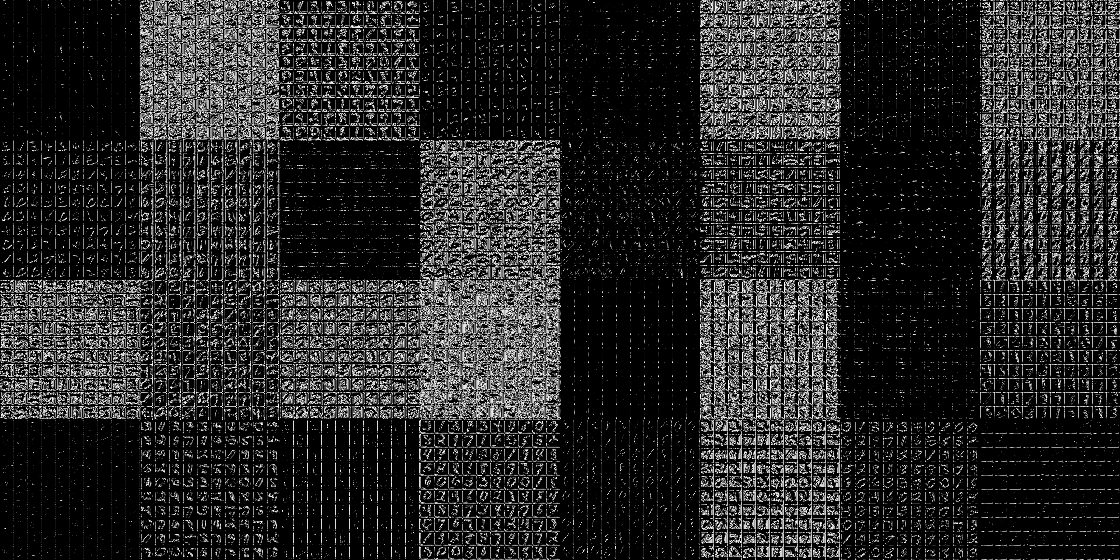

In [11]:
img_show(cov2)

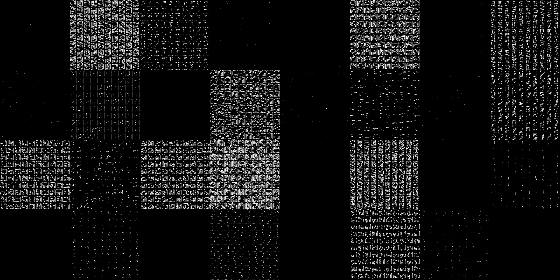

In [12]:
img_show(pol2)

In [16]:
#print('cov1 min:', cov1.min())
print('cov1 max:', cov1.max())
print('cov1 mean:', cov1.mean())
print('cov1 std:', cov1.std())
#print('pol1 min:', pol1.min())
print('pol1 max:', pol1.max())
print('pol1 mean:', pol1.mean())
print('pol1 std:', pol1.std())
#print('cov2 min:', cov2.min())
print('cov2 max:', cov2.max())
print('cov2 mean:', cov2.mean())
print('cov2 std:', cov2.std())
#print('pol2 max:', pol2.min())
print('pol2 max:', pol2.max())
print('pol2 mean:', pol2.mean())
print('pol2 std:', pol2.std())
print('layA max:', layA.max())
#print('layA min:', layA.min())
print('layA mean:', layA.mean())
print('layA std:', layA.std())
print('layB max:', layB.max())
#print('layB min:', layB.min())
print('layB mean:', layB.mean())
print('layB std:', layB.std())
#print('X max:', x_train.max())
#print('X min:', x_train.min())
print('X mean:', x_train.mean())
print('X std:', x_train.std())

cov1 max: 5.4565926
cov1 mean: 0.5380697
cov1 std: 0.8205356
pol1 max: 4.3381267
pol1 mean: 0.38565814
pol1 std: 0.6367999
cov2 max: 15.130559
cov2 mean: 0.6864674
cov2 std: 1.5065887
pol2 max: 7.109142
pol2 mean: 0.1981215
pol2 std: 0.6135784
layA max: 7.3225937
layA mean: 0.36030167
layA std: 0.94854003
layB max: 30.933952
layB mean: 3.9136105
layB std: 6.056847
X mean: 0.8693392
X std: 0.30810776
